# RNN Lab - Sentiment Classification

In [308]:
# importing relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download(["stopwords", "punkt", "wordnet"])
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading data

In [285]:
data = pd.read_csv("../Lab_RNN/Data/emotions.csv") # creating data frame from the csv file

data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [286]:
data.value_counts # using value count to count how many rows in data frame

<bound method DataFrame.value_counts of                                                     text    label
0      i feel so pissed off over an old friend and so...    anger
1      ive found it has made a huge difference especi...    anger
2      i also feel it is unfortunate that nearly all ...  sadness
3                       i feel petty a href http clairee    anger
4      i used to believe that a feeling like fear was...  sadness
...                                                  ...      ...
19995  i was i might be buying stuff from there but i...      joy
19996  i like sonam deepika and genelia who i feel ar...      joy
19997  i feel pathetic that i can hardly go a whole d...  sadness
19998  id have spent more time with her on reading i ...  sadness
19999  i do however feel like one of those pathetic g...  sadness

[20000 rows x 2 columns]>

In [287]:
# Checking for any null values
data.isnull().sum()

text     0
label    0
dtype: int64

In [288]:
duplicates =data[data.duplicated]
print(f"Duplicates {duplicates}")

Duplicates                                                    text label
6154  i feel more adventurous willing to take risks ...   joy


In [289]:
# remove duplicates
data = data.drop_duplicates()

The data set contains 20,000 rows of text lines then classed with an emotion.

<Axes: xlabel='label'>

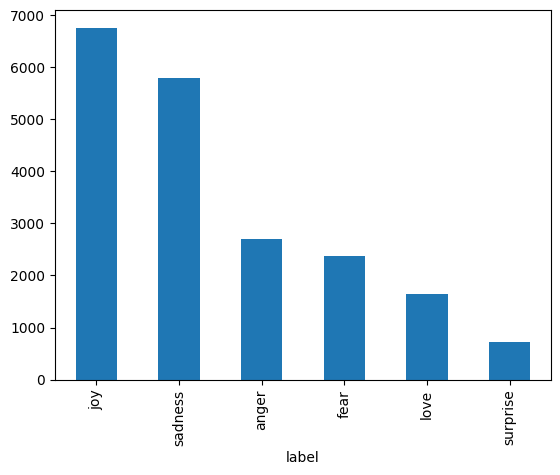

In [290]:
data.label.value_counts().plot.bar() 

Here we can see that the data set is not very equal across all catagories. This may make the training more biased to certain emotions like joy and sadness. We also see that there is six different catagories for the emotions.

#### Preprocessing

In [291]:
# Even though the data does not seem to have and Upper case or punctuation it may be good to do as there is many lines to check through manually
data.loc[:, "text"] = data["text"].str.lower().str.replace('[^\w\s]','') # convert text to lowercase and remove punctuation
data.loc[:, "label"] = data["label"].str.lower().str.replace('[^\w\s]','')

In [292]:
# create a preproccessing function that will process the text column

def preprocess_text(text):
    
    # convert text to lowercase
    text = text.lower()

    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text



In [293]:
data.loc[:, "text"] = data["text"].apply(preprocess_text)
data

,text,label
0,feel pissed old friend friend,anger
1,ive found made huge difference especially fing...,anger
2,also feel unfortunate nearly reader going meet...,sadness
3,feel petty href http clairee,anger
4,used believe feeling like fear ignored suppres...,sadness
...,...,...
19995,might buying stuff feel clothes casual,joy
19996,like sonam deepika genelia feel talented beaut...,joy
19997,feel pathetic hardly go whole day talking,sadness
19998,id spent time reading feel bit guilty,sadness


In [294]:
# checking the length of the strings so that i have an idea of how long i should make the max words in the sequence length for padding
print(pd.Series(data["text"]).str.len().mean())
print(pd.Series(data["text"]).str.len().max())

60.805790289514476
229


This gives a rough idea that every string has an average of 60 words and that the longest sentence has 229 words. I can use a box plot to see more clearly

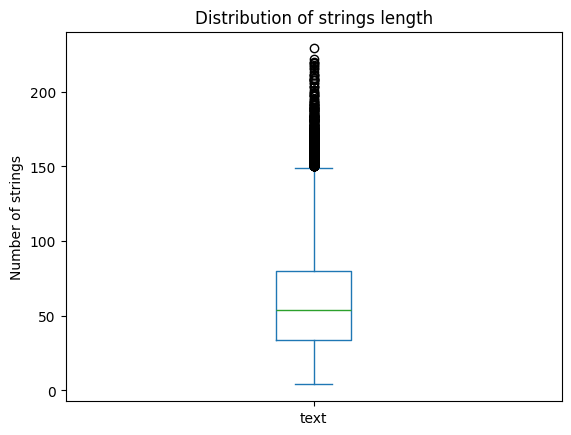

count    19999.000000
mean        60.805790
std         34.519413
min          4.000000
25%         34.000000
50%         54.000000
75%         80.000000
max        229.000000
Name: text, dtype: float64

In [295]:
strings_len = pd.Series(data["text"]).str.len()

strings_len.plot.box()
plt.title("Distribution of strings length")
plt.ylabel("Number of strings")
plt.show()

strings_len.describe()

You can see most strings are up to 150 words. But with using the describe function on the length of the strings we can see that around 75 % of the comments are up to 80 words long. This will be taken into account when padding. Some sentences may be shorter so they will need to have padding. (explain this more) 

#### Preparing text to be used with Deep learning model

I will now tokenize the text and pad it. I will also one hot code the labels.

In [296]:
# encoding emotions
encoded_emotions = {
    "anger" : 0,
    "fear": 1,
    "joy" : 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

data.replace(encoded_emotions, inplace = True)
data.head()

/tmp/ipykernel_6194/2507044824.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace(encoded_emotions, inplace = True)


,text,label
0,feel pissed old friend friend,0
1,ive found made huge difference especially fing...,0
2,also feel unfortunate nearly reader going meet...,4
3,feel petty href http clairee,0
4,used believe feeling like fear ignored suppres...,4


In [297]:
# Splitting the data into train, val and test before toeknization and padding

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"X_train = {X_train.shape} and y_train = {y_train.shape}")
print(f"X_test = {X_test.shape} and y_test = {y_test.shape}")
print(f"X_val = {X_val.shape} and y_val = {y_val.shape}")


X_train = (11999,) and y_train = (11999,)
X_test = (4000,) and y_test = (4000,)
X_val = (4000,) and y_val = (4000,)


In [306]:
# Tokenize the text data

max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.astype(str))

X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(tokenizer.word_index)

for i in range (10):
    print(f"Sequence {i + 1}: {X_train_seq[i]}")


11491
{'feel': 1, 'feeling': 2, 'like': 3, 'im': 4, 'time': 5, 'really': 6, 'know': 7, 'get': 8, 'make': 9, 'little': 10, 'day': 11, 'people': 12, 'want': 13, 'one': 14, 'thing': 15, 'would': 16, 'life': 17, 'still': 18, 'think': 19, 'even': 20, 'ive': 21, 'way': 22, 'bit': 23, 'going': 24, 'much': 25, 'something': 26, 'love': 27, 'dont': 28, 'could': 29, 'back': 30, 'need': 31, 'go': 32, 'good': 33, 'pretty': 34, 'see': 35, 'always': 36, 'right': 37, 'say': 38, 'also': 39, 'friend': 40, 'year': 41, 'today': 42, 'work': 43, 'made': 44, 'around': 45, 'cant': 46, 'though': 47, 'come': 48, 'help': 49, 'got': 50, 'lot': 51, 'didnt': 52, 'someone': 53, 'felt': 54, 'thought': 55, 'le': 56, 'never': 57, 'well': 58, 'every': 59, 'quite': 60, 'week': 61, 'look': 62, 'sure': 63, 'enough': 64, 'find': 65, 'many': 66, 'home': 67, 'happy': 68, 'better': 69, 'kind': 70, 'away': 71, 'left': 72, 'anything': 73, 'last': 74, 'ever': 75, 'actually': 76, 'trying': 77, 'take': 78, 'everything': 79, 'gettin

In [307]:
max_sequence_length = 80

X__train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post")
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

for i in range (3):
    print(f"Sequence{i +1}: {X__train_padded[i]}")


Sequence1: [130   1 730   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
Sequence2: [1349 5601  558 5602 1519 3139 5603 2334   44 1519 3139  228  157 1426
 1628  214    2    1  152  126  126 1756  893   45  177  140 1427   11
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Sequence3: [  21  846  185 2335 5604 1290   91    5  757   73 1520    9    1  775
  232   53 1223 3140 5605  991   87  259  495  674    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

In [313]:
# converting to Tensorflow tensors for the model
X_train_tensor = tf.constant(X__train_padded, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))

X_val_tensor = tf.constant(X_val_padded, dtype=tf.int32)
y_val_tensor = tf.constant(y_val, dtype=tf.int32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))

print(train_dataset)
print(val_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(80,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(80,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
